### 피부색 추출 알고리즘 병합
    
    최초 작성일 : 20/02/19
    작성자 : 양희승
    
    작성내용 : 피부색 추출 시 모든 과정 통합
               
               원본사진
               (white balace test)
               -> 화이트밸런스 조정 
                              
               (face_detection_test)
               -> 얼굴 인식
               -> 크롭
               -> 저장  ##20/02/20
               
               (resizing_img)
               -> 리사이징
               -> 볼 인식
               -> 볼 두개 이미지 평균 이미지 추출
               -> 평균색으로 이미지 변환
               
               (color_convert_test)
               -> 평균색 GBR - RGB 변환
               -> RGB - HSV 변환
               
               (조예슬씨 코드)
               -> HSV 분석
               -> 웜 쿨 구분 후 
               -> 반환 값
               
               
               -> 결과값 저장
               -> 입력값???
    
    수정내용 
        20/02/20
            사진 리사이징 추가로 인한 성능 개선
                resizing_img 함수 추가  120*120으로 고정
                
            코드 수정
                face_detection에서 얼굴인식 크롭에서 종료시키고
                face_detection에서 볼인식 부분은 따로 함수 재설정
            
            
            코드 추가
                cheek_detection 함수 추가 
                
            팀원(조예슬) 코드 추가//테스트
                color_classifier(person_HSV)
                
                
        20/02/21
            함수 추가
                shadow_process  (그림자 제거) 함수
                
        
        20/02/22
            white_balance 함수 수정 
                색깔 올바르게 변환시키기
            
            cheek_detection 함수 수정
                눈 검출 표준화

In [1]:
import cv2 as cv
import numpy as np
import colour
import utils
import matplotlib.pyplot as plt
import math

In [2]:
# 화이트 밸런스 변환
def apply_mask(matrix, mask, fill_value):
    masked = np.ma.array(matrix, mask=mask, fill_value=fill_value)
    return masked.filled()

def apply_threshold(matrix, low_value, high_value):
    low_mask = matrix < low_value
    matrix = apply_mask(matrix, low_mask, low_value)

    high_mask = matrix > high_value
    matrix = apply_mask(matrix, high_mask, high_value)

    return matrix

def white_balance(img, percent, file_name):
    assert img.shape[2] == 3
    assert percent > 0 and percent < 100

    half_percent = percent / 200.0

    channels = cv.split(img)

    out_channels = []
    for channel in channels:
        assert len(channel.shape) == 2
        # find the low and high precentile values (based on the input percentile)
        height, width = channel.shape
        vec_size = width * height
        flat = channel.reshape(vec_size)

        assert len(flat.shape) == 1

        flat = np.sort(flat)

        n_cols = flat.shape[0]

        low_val  = flat[math.floor(n_cols * half_percent)]
        high_val = flat[math.ceil( n_cols * (1.0 - half_percent))]

        print("Lowval: ", low_val)
        print("Highval: ", high_val)

        # saturate below the low percentile and above the high percentile
        thresholded = apply_threshold(channel, low_val, high_val)
        # scale the channel
        normalized = cv.normalize(thresholded, thresholded.copy(), 0, 255, cv.NORM_MINMAX)
        out_channels.append(normalized)
        
    out = cv.merge(out_channels)
    cv.imwrite("img/"+file_name+"_1.jpg", out)
#         cv.imshow("before", img)
#         cv.imshow("after", out)
#     cv.waitKey(0)
    return out

In [18]:
# 얼굴 인식
def face_detection(img, file_name) :
    origin_img = img
    
    faceCascade = cv.CascadeClassifier('data/haarcascade_frontface.xml') 

    gray = cv.cvtColor(origin_img, cv.COLOR_BGR2GRAY) 
    faces = faceCascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=3, minSize=(100, 100)) 

    face_cropped = None

    # face_detection
    if len(faces) > 1 :
        print("한 사람만 찍힌 사진을 올려주세요")
        face_cropped = [0,0,0]
    elif len(faces) == 1 :
        for (x, y, w, h) in faces: 
            cv.rectangle(origin_img, (x, y), (x+w, y+h), (0, 255, 0), 2) 
#             cv.imshow("Face", origin_img) 
            cv.imwrite("img/"+file_name+"_2.jpg", origin_img)
            face_cropped = origin_img[y:y + h, x:x + w]
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = origin_img[y:y+h, x:x+w]
            cv.imwrite("img/"+file_name+"_3.jpg", face_cropped)

    elif len(faces) == 0 :
        print("정면이거나 정상적인 사진을 올려주세요")
        face_cropped = [0,0,0]
    else :
        print("에러")
        face_cropped = [0,0,0]


    return face_cropped

In [19]:
# resizing
def resizing_img(img, file_name) :
    h,w,r = img.shape
#     img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    print(h,w,r)
    print(file_name)
    
    if h > w :
        pass
    elif h < w :
        pass
    elif h == w :
        mul = round((120/h), 3)        
        resz_img = cv.resize(img, None, fx=mul, fy=mul, interpolation=cv.INTER_AREA)
        h, w, r = resz_img.shape
    else :
        pass
        
    print(h,w,r)
    cv.imwrite("img/"+file_name+"_4.jpg", resz_img)
    return resz_img

In [45]:
# 볼 인식

def cheek_detection(img, file_name) :
    face_cropped = img
    gray = cv.cvtColor(face_cropped, cv.COLOR_BGR2GRAY) 
    faceCascade_eye = cv.CascadeClassifier('data/haarcascade_eye.xml') 

    eyes = faceCascade_eye.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=3, minSize=(25, 25)) 

    cheek_cropped = None    
    
    temp_img = face_cropped  
    
    print("눈갯수 : ",len(eyes))
    if len(eyes) == 2 :
        # cheek_detection
        for i in range(len(eyes)): 
            x, y, w, h = eyes[i]
            if i == 0 :
    #             cheek_cropped1 = temp_img[y+40:y+40+15, x-5:x+25]            
                cheek_cropped1 = temp_img[y:y+20, x:x+w]
            elif i == 1 :
    #             cheek_cropped2 = temp_img[y+40:y+40+15, x+10:x+40]
                cheek_cropped2 = temp_img[y:y+20, x:x+w]
        final = np.hstack((cheek_cropped1, cheek_cropped2))    
        cv.imwrite("img/"+file_name+"_6.jpg", final)

        for i in range(len(eyes)): 
            x, y, w, h = eyes[i]        
            if i == 0 :
    #             cv.rectangle(face_cropped, (x-5, y+40), (x+25, y+40+15), (0, 255, 0), 2)
                cv.rectangle(face_cropped, (x, y), (x+w, y+20), (0, 255, 0), 2)
            elif i == 1 :
    #             cv.rectangle(face_cropped, (x+10, y+40), (x+40, y+40+15), (0, 255, 0), 2) 
                cv.rectangle(face_cropped, (x, y), (x+w, y+20), (0, 255, 0), 2)
                cv.imwrite("img/"+file_name+"_5.jpg", face_cropped)
            
    elif len(eyes) == 1 :
        print("왜 눈이 하나만 검출되었죠?")
        
    else : 
        print("눈을 인식할 수 없습니다. ")

    
    
    return final

In [21]:
def shadow_process(img, file_name) :
#     img = cv.imread("img/"+file_name+".jpg", -1)

    rgb_planes = cv.split(img)

    result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv.medianBlur(dilated_img, 21)
        diff_img = 255 - cv.absdiff(plane, bg_img)
        norm_img = cv.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)
        result_planes.append(diff_img)
        result_norm_planes.append(norm_img)

    shadow_img = cv.merge(result_planes)
    result_img = img - shadow_img
    cv.imwrite("img/"+file_name+"_7.jpg", result_img)
    
    return result_img

In [22]:
# 볼 평균색 HSV 변환
def color_convert(cheek, file_name) :
    img = cheek
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    
    sum = 0
    R = []
    G = []
    B = []
    for i in img :
        for j in i :
            R.append(j[0])
            G.append(j[1])
            B.append(j[2])

    R_sum = 0
    G_sum = 0
    B_sum = 0

    # 각 R, G, B의 합계 구하기
    for i in range(len(R)) :
        R_sum += R[i]
        G_sum += G[i]
        B_sum += B[i]

    R_avg = int(round((R_sum / len(R)), 0))  # R값 평균
    G_avg = int(round((G_sum / len(G)), 0))  # G값 평균
    B_avg = int(round((B_sum / len(B)), 0))  # B값 평균
    RGB_color = [R_avg, G_avg, B_avg]
    
    
    # 평균 색만 그래프 그리기 위함 img_avg
    img_avg = img

    for i in img_avg :
        for j in i :
            j[0] = R_avg
            j[1] = G_avg
            j[2] = B_avg

    # 기존        
    plt.imshow(img)
    plt.show()

    # 평균색
    plt.imshow(img_avg)
    plt.show()
    bgr_img_avg = cv.cvtColor(img_avg, cv.COLOR_RGB2BGR)

    # 저장
    cv.imwrite("img/"+file_name+"_8.jpg", bgr_img_avg)
    
    
    arr_RGB_color = np.array(RGB_color)
    float_arr_RGB_color = arr_RGB_color / 255
    float_tp_RGB_color = tuple(float_arr_RGB_color)
    HSV_color = colour.RGB_to_HSV(float_tp_RGB_color)
    HSV_color2 = np.array([round(HSV_color[0]*359, 3), round(HSV_color[1] * 100, 3), round(HSV_color[2] * 100, 3)])
#     print("HSV 값 : ", HSV_color2)
    HSV_color2 = list(HSV_color2)
    HSV_color2[0] = round(HSV_color2[0], 2)
    HSV_color2[1] = round(HSV_color2[1], 2)
    HSV_color2[2] = round(HSV_color2[2], 2)
    return HSV_color2


In [23]:
def color_classifier(person_HSV) :    
    
    # 입력값 Hue, Sturation, Value에 따라 변수 지정
    H = float(person_HSV[0])
    S = float(person_HSV[1])
    V = float(person_HSV[2])
    diff = round(V - S, 2)
    
    color_type = ["WSB", "WSL", "WAD", "WAM", "CSL", "CSM", "CWB", "CWD"]
    
    if H >= 26 and H <= 206 : 
        if diff >= 43.15 :
            if S >= 32.47 :
                ans = 0
                # Warm Spring Bright                            
            else :
                ans = 1
                # Warm Spring Light
                                
        elif diff <= 43.15:
            if S >= 32.47 :
                ans = 2
                # Warm Autumn Deep                
            else :
                ans = 3
                # Warm Autumn Mute
                

                
    elif (H >= 0 and H <= 25) or (H >= 207 and H <= 359) :
        if diff >= 47.15 :
            if diff >= 60.80 :
                ans = 4
                # Cool Summer Light                
            else :
                ans = 5
                # Cool Summer Mute
                                
        elif diff <= 47.15:
            if diff >= 23.58 :
                ans = 6
                # Cool Winter Bright                
            else :
                ans = 7
                # Cool Winter Deep
                
                
    else :
        ans = -1
        # 에러
    
    
    return ans

Lowval:  38
Highval:  242
Lowval:  22
Highval:  238
Lowval:  16
Highval:  239
144 144 3
origin
120 120 3
눈갯수 :  2


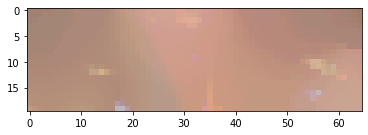

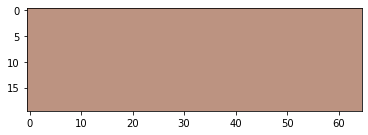

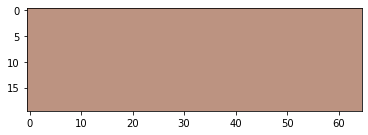

입력 값 : 
HSV 결과 값 [18.25, 31.379999999999999, 73.719999999999999]
타입 번호 :  6
당신은 : CWB 입니다.


In [47]:
color_type = ["WSB", "WSL", "WAD", "WAM", "CSL", "CSM", "CWB", "CWD"]

file_name = "origin"
img = cv.imread("img/"+file_name+".jpg")

wb_img = white_balance(img, 1, file_name)
face_cropp = face_detection(wb_img, file_name) #_2, _3
resize_img = resizing_img(face_cropp, file_name) #_4
cheek_cropp = cheek_detection(resize_img, file_name) #_5, _6
rm_shadow = shadow_process(cheek_cropp, file_name)
hsv = color_convert(rm_shadow, file_name) # _7

color_type_num = color_classifier(hsv)
print("입력 값 : ")
print("HSV 결과 값", hsv)
print("타입 번호 : ", color_type_num)
print("당신은 : {} 입니다.".format(color_type[color_type_num]))